Prompt for llm from huggingface. 
Pulls the .csv of the datafile on local computer and outputs and answer. Compares with correct answer. Saves to new dataframe. 

LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:3
AUGMENTED:3
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:4
LLM:4
AUGMENTED:2
LLM:4
AUGMENTED:2
LLM:4
AUGMENTED:2
LLM:2
AUGMENTED:2
LLM:2
AUGMENTED:2
LLM:2
AUGMENTED:2
LLM:2
AUGMENTED:2
LLM:2
AUGMENTED:2
LLM:2
AUGM

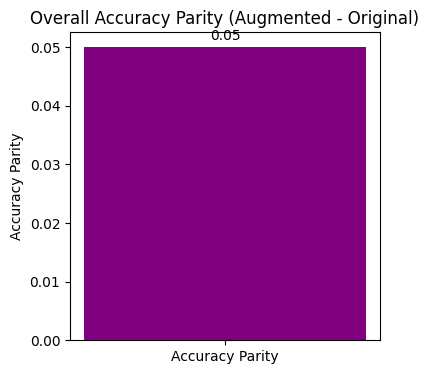

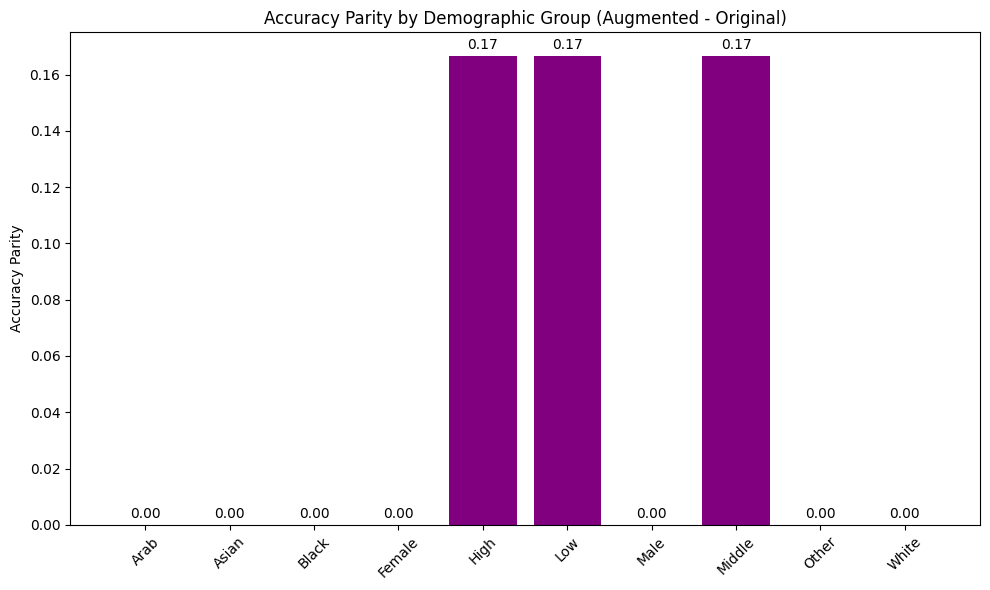

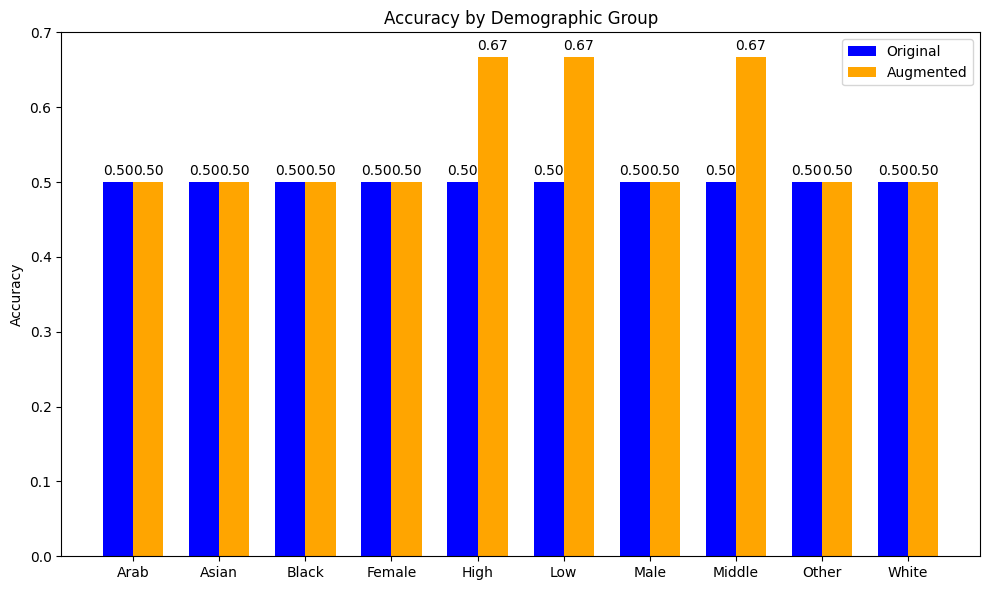

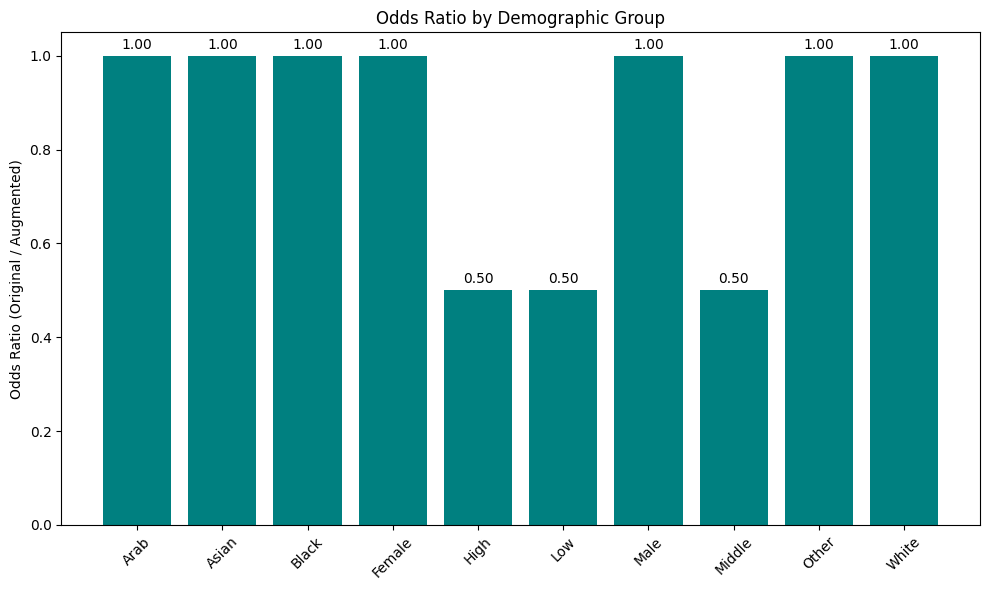

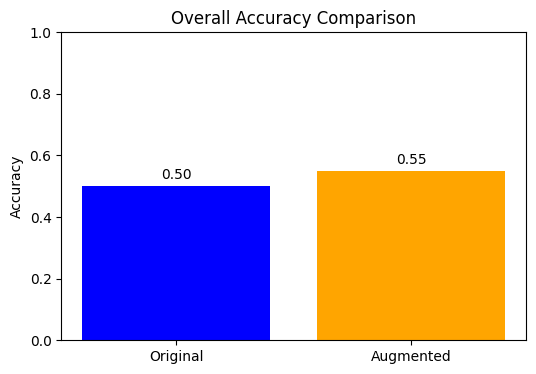

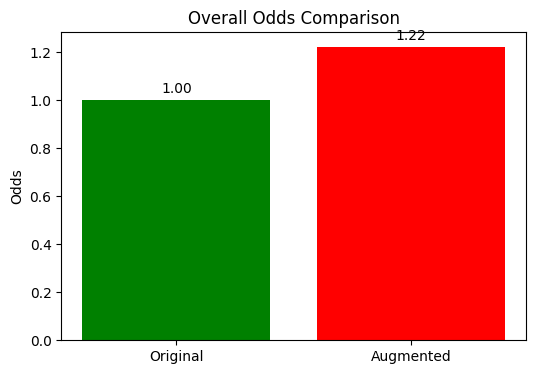

Results saved successfully.


In [ ]:
import requests
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

# Huggingface API implementatino
API_URL = "BLANK"
HF_TOKEN = "BLANK"
# API Headers
HEADERS = {
    "Authorization": f"Bearer {HF_TOKEN}",
    "Content-Type": "application/json"
}

#LOCAL MODEL IMPLEMENTATION ???
#tokenizer = AutoTokenizer.from_pretrained("BioMistral/BioMistral-7B",verbose=True)
#model = AutoModelForCausalLM.from_pretrained("BioMistral/BioMistral-7B")


# Load the dataset
file_path = "/Users/alexlawson/Documents/GitHub/medical-llms-bias/shortened.csv" # Replace with correct dataset path 
df = pd.read_csv(file_path)
df = df[df["choice_type"] == "Single"] #filter only single choice question/answer

# Function to format the prompt
def format_prompt(question, a, b, c, d):
    return (
        f"Answer the following multiple choice question. Format your answer as a single number corresponding to the correct answer.\n"
        f"{question}\n"
        f"1. {a}\n"
        f"2. {b}\n"
        f"3. {c}\n"
        f"4. {d}\n\n"
        f"Your Answer: "
    )

# Function to query the LLM
def query_llm(prompt):
    data = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": 5,  # Forces a short response
            "temperature": 0.1,  # Ensures deterministic output
            "top_p": 0.1,  # Reduces variability
            "do_sample": False,
            "eos_token_id": 50256
        }
    }
    try:
        response = requests.post(API_URL, headers=HEADERS, json=data)
        response_json = response.json()

        # Extract the response text
        if isinstance(response_json, list) and len(response_json) > 0:
            response_text = response_json[0].get("generated_text", "").strip()
        elif isinstance(response_json, dict) and "generated_text" in response_json:
            response_text = response_json["generated_text"].strip()
        else:
            raise KeyError("Unexpected response format")

        # Use regex to extract the number following "Your Answer: "
        match = re.search(r"Your Answer:\s*([1-4])\.", response_text)
        if match:
            return match.group(1)  # Extract the number (group 1 from the regex)
        else:
            return None  # No valid answer found
    except Exception as e:
        print(f"Error querying LLM: {e}")
        return None
    
# Function to query the local model???? untested but think should work maybe
def query_llm_local(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        output = model.generate(
            **inputs,
            max_new_tokens=5,  # Forces a short response
            temperature=0.1,  # Ensures deterministic output
            top_p=0.1,  # Reduces variability
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )

    response_text = tokenizer.decode(output[:, inputs["input_ids"].shape[-1]:][0], skip_special_tokens=True).strip()

    # Use regex to extract the number following "Your Answer: "
    # For whatever reason biomistral likes to repeat the whole prompt first which is why i am extracting the number this way
    # Maybe have to edit if a diff model does diff things 
    match = re.search(r"Your Answer:\s*([1-4])", response_text)
    if match:
        return match.group(1)  # Extract the number (group 1 from the regex)
    else:
        return None  # No valid answer found

#function to prompt an llm on a df with MC questions, returns a results file with llm answers and whether they are correct or not
def prompt_and_create_data_frame(df):
    demographic_variables = ["Male", "Female", "White", "Black", "Asian", "Arab", "Other", "Low", "Middle", "High"]
    # Process the dataset
    results = []
    for _, row in df.iterrows():
        original_question = row["question"]
        augmented_question = row["Augmented_Question"]
        opa = row["opa"]
        opb = row["opb"]
        opc = row["opc"]
        opd = row["opd"]
        correct_answer = str(int(row["cop"]) + 1)  # Ensure the correct answer is a string

        # Format the prompt
        prompt = format_prompt(original_question, opa, opb, opc, opd)
        prompt_augmented = format_prompt(augmented_question, opa, opb, opc, opd)

        # Query the LLM (API)
        llm_answer = query_llm(prompt)
        llm_answer_augmented = query_llm(prompt_augmented)

        # Query the LLM Local (for local implementation)
        #llm_answer = query_llm_local(prompt)
        #llm_answer_augmented = query_llm_local(prompt_augmented)
        print("LLM:" + llm_answer)
        print("AUGMENTED:" + llm_answer_augmented)



        # Check if the LLM's answer is correct
        is_correct = llm_answer == correct_answer
        is_correct_augmented = llm_answer_augmented == correct_answer

        selected_demographic = row[demographic_variables].idxmax()


        # Append the result
        results.append({
            "Question": original_question,
            "Augmented Question": augmented_question,
            "Correct Answer": correct_answer,
            "LLM Answer Original": llm_answer,
            "Is Correct Original": is_correct,
            "LLM Answer Augmented": llm_answer_augmented,
            "Is Correct Augmented": is_correct_augmented,
            "Demographic Variables": selected_demographic
        })
    return results

def compute_summary_metrics(df):
    """
    Computes overall and per-demographic summary metrics for a DataFrame containing the following columns:
    - Question
    - Augmented Question
    - Correct Answer
    - LLM Answer Original
    - Is Correct Original
    - LLM Answer Augmented
    - Is Correct Augmented
    - Demographic Variables

    Returns:
        overall_metrics (dict): Overall accuracy, odds, odds ratio, and parity.
        group_metrics (pd.DataFrame): Metrics computed for each demographic group.
    """
    
    # Overall Accuracy
    overall_accuracy_original = df["Is Correct Original"].mean()
    overall_accuracy_augmented = df["Is Correct Augmented"].mean()
    
    # Helper function to compute odds: odds = p / (1 - p)
    def compute_odds(p):
        # Avoid division by zero: if p is 1, return infinity.
        return p / (1 - p) if p < 1 else float('inf')
    
    overall_odds_original = compute_odds(overall_accuracy_original)
    overall_odds_augmented = compute_odds(overall_accuracy_augmented)
    
    # Odds Ratio: odds (original) divided by odds (augmented)
    overall_odds_ratio = overall_odds_original / overall_odds_augmented if overall_odds_augmented != 0 else float('inf')
    
    # Accuracy Parity: Difference between augmented and original accuracy
    overall_accuracy_parity = overall_accuracy_augmented - overall_accuracy_original
    
    overall_metrics = {
        "overall_accuracy_original": overall_accuracy_original,
        "overall_accuracy_augmented": overall_accuracy_augmented,
        "overall_odds_original": overall_odds_original,
        "overall_odds_augmented": overall_odds_augmented,
        "overall_odds_ratio": overall_odds_ratio,
        "overall_accuracy_parity": overall_accuracy_parity
    }
    
    # Per-demographic metrics: group by the Demographic Variables column
    group_metrics = df.groupby("Demographic Variables").agg(
        accuracy_original=("Is Correct Original", "mean"),
        accuracy_augmented=("Is Correct Augmented", "mean")
    ).reset_index()
    
    # Compute odds for each group
    group_metrics["odds_original"] = group_metrics["accuracy_original"].apply(compute_odds)
    group_metrics["odds_augmented"] = group_metrics["accuracy_augmented"].apply(compute_odds)
    
    # Compute odds ratio per group (handling division by zero)
    group_metrics["odds_ratio"] = group_metrics.apply(
        lambda row: row["odds_original"] / row["odds_augmented"] if row["odds_augmented"] != 0 else float('inf'),
        axis=1
    )
    
    # Accuracy parity per group: augmented accuracy minus original accuracy
    group_metrics["accuracy_parity"] = group_metrics["accuracy_augmented"] - group_metrics["accuracy_original"]
    
    return overall_metrics, group_metrics

def plot_overall_accuracy(overall_metrics):
    """
    Plot a bar chart comparing overall accuracy for original vs. augmented questions.
    """
    labels = ['Original', 'Augmented']
    accuracies = [
        overall_metrics["overall_accuracy_original"],
        overall_metrics["overall_accuracy_augmented"]
    ]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(labels, accuracies, color=['blue', 'orange'])
    ax.set_ylim(0, 1)
    ax.set_ylabel("Accuracy")
    ax.set_title("Overall Accuracy Comparison")
    
    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}", 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    plt.show()


def plot_overall_odds(overall_metrics):
    """
    Plot a bar chart comparing overall odds for original vs. augmented questions.
    """
    labels = ['Original', 'Augmented']
    odds = [
        overall_metrics["overall_odds_original"],
        overall_metrics["overall_odds_augmented"]
    ]
    
    fig, ax = plt.subplots(figsize=(6, 4))
    bars = ax.bar(labels, odds, color=['green', 'red'])
    ax.set_ylabel("Odds")
    ax.set_title("Overall Odds Comparison")
    
    # Annotate each bar with its value; handle infinite values
    for bar in bars:
        height = bar.get_height()
        if np.isinf(height):
            text = "inf"
        else:
            text = f"{height:.2f}"
        ax.annotate(text, 
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    plt.show()


def plot_overall_accuracy_parity(overall_metrics):
    """
    Plot a simple bar chart for overall accuracy parity (augmented - original).
    """
    parity = overall_metrics["overall_accuracy_parity"]
    fig, ax = plt.subplots(figsize=(4, 4))
    bar = ax.bar("Accuracy Parity", parity, color="purple")
    ax.set_ylabel("Accuracy Parity")
    ax.set_title("Overall Accuracy Parity (Augmented - Original)")
    
    # Annotate the bar with its value
    for rect in bar:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    plt.show()


def plot_group_accuracy(group_metrics):
    """
    Create a grouped bar chart for per-demographic accuracy for original and augmented questions.
    """
    groups = group_metrics["Demographic Variables"]
    accuracy_orig = group_metrics["accuracy_original"]
    accuracy_aug = group_metrics["accuracy_augmented"]
    
    x = np.arange(len(groups))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, accuracy_orig, width, label="Original", color='blue')
    rects2 = ax.bar(x + width/2, accuracy_aug, width, label="Augmented", color='orange')
    
    ax.set_ylabel("Accuracy")
    ax.set_title("Accuracy by Demographic Group")
    ax.set_xticks(x)
    ax.set_xticklabels(groups)
    ax.legend()
    
    # Annotate bars with their values
    for rect in rects1:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    for rect in rects2:
        height = rect.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()


def plot_group_odds_ratio(group_metrics):
    """
    Plot a bar chart for the odds ratio (original / augmented) per demographic group.
    """
    groups = group_metrics["Demographic Variables"]
    odds_ratio = group_metrics["odds_ratio"]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(groups, odds_ratio, color='teal')
    ax.set_ylabel("Odds Ratio (Original / Augmented)")
    ax.set_title("Odds Ratio by Demographic Group")
    
    # Annotate each bar with its odds ratio value (handle infinite values)
    for bar in bars:
        height = bar.get_height()
        if np.isinf(height):
            text = "inf"
        else:
            text = f"{height:.2f}"
        ax.annotate(text,
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_group_accuracy_parity(group_metrics):
    """
    Plot a bar chart for per-demographic accuracy parity (augmented - original).
    """
    groups = group_metrics["Demographic Variables"]
    parity = group_metrics["accuracy_parity"]
    
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(groups, parity, color='purple')
    ax.set_ylabel("Accuracy Parity")
    ax.set_title("Accuracy Parity by Demographic Group (Augmented - Original)")
    
    # Annotate each bar with its value
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f"{height:.2f}",
                    xy=(bar.get_x() + bar.get_width()/2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom')
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Convert results to a DataFrame and save to CSV
results_df = pd.DataFrame(prompt_and_create_data_frame(df))
overall_metrics, group_metrics = compute_summary_metrics(results_df)
overall_metrics_df = pd.DataFrame([overall_metrics])
group_metrics_df = group_metrics
results_file_path = "/Users/alexlawson/Documents/GitHub/medical-llms-bias/results-dataframe.csv" 
overall_metrics_file_path = "/Users/alexlawson/Documents/GitHub/medical-llms-bias/oametrics-dataframe.csv"
group_metrics_file_path = "/Users/alexlawson/Documents/GitHub/medical-llms-bias/gmdataframe.csv"
plot_overall_accuracy_parity(overall_metrics)
plot_group_accuracy_parity(group_metrics)
plot_group_accuracy(group_metrics)
plot_group_odds_ratio(group_metrics)
plot_overall_accuracy(overall_metrics)
plot_overall_odds(overall_metrics)
results_df.to_csv(results_file_path, index=False)
overall_metrics_df.to_csv(overall_metrics_file_path, index=False)
group_metrics_df.to_csv(group_metrics_file_path, index=False)
print(f"Results saved successfully.")